multivariate times series, 
regular times series, 
var model et non arima, 
verifier si stationnary, 
use referencing if not, 
todo : dans le "pd.to_datetime(data_raw['timestamp'])" mettre "B" pour business day





In [1]:
#importing the libraries
import numpy as np
import math
import pandas as pd
from datetime import datetime, timedelta, time
from vacances_scolaires_france import SchoolHolidayDates
import sys
from impyute.imputation.cs import mice
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from pandas.plotting import autocorrelation_plot
import functools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
import seaborn as sns
#pip install vacances-scolaires-france
#pip3 install impyute
#pip install statsmodels
# my fonctions
def conv(data):
    data["date"] = data.timestamp.apply(lambda x : x.split('T')[0])
    data["datetime_perso"] = data.timestamp.apply(lambda x : get_format_the_date(x))
    data['year']=data['datetime_perso'].dt.year
    data['month']=data['datetime_perso'].dt.month
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['hours'] = data['timestamp'].dt.hour
    return data

## get season
def get_season(doy):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if doy in spring:
        season = 'spring'
    elif doy in summer:
      season = 'summer'
    elif doy in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

## verifie si jour ferie
def easter_date(year):
    a = year // 100
    b = year % 100
    c = (3 * (a + 25)) // 4
    d = (3 * (a + 25)) % 4
    e = (8 * (a + 11)) // 25
    f = (5 * a + b) % 19
    g = (19 * f + c - e) % 30
    h = (f + 11 * g) // 319
    j = (60 * (5 - d) + b) // 4
    k = (60 * (5 - d) + b) % 4
    m = (2 * j - k - g + h) % 7
    n = (g - h + m + 114) // 31
    p = (g - h + m + 114) % 31
    day = p + 1
    month = n
    return datetime(year, month, day)

def is_ferie(the_date):
    year = the_date.year
    easter = easter_date(year)
    days = [
        datetime(year, 1, 1),  # Premier de l'an
        easter + timedelta(days=1),  # Lundi de Pâques
        datetime(year, 5, 1),  # Fête du Travail
        datetime(year, 5, 8),  # Victoire de 1945
        easter + timedelta(days=39),  # Ascension
        easter + timedelta(days=49),  # Pentecôte
        datetime(year, 7, 14),  # Fête Nationale
        datetime(year, 8, 15),  # Assomption
        datetime(year, 11, 1),  # Toussaint
        datetime(year, 11, 11),  # Armistice 1918
        datetime(year, 12, 25),  # Noël
    ]
    return the_date in days

def get_format_the_date(timestamp):
    do = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%f')
    d5 = do.replace(minute=0, hour=0, second=0, microsecond=0).isoformat(' ')
    the_date = datetime.strptime(d5, "%Y-%m-%d %H:%M:%S")
    return the_date

def business_day(timestamp):
    if not is_ferie(timestamp) and timestamp.isoweekday() not in [6, 7]:
        return True
    else:
        return False
    
  

In [2]:
# Creating the test for stationarity
def test_stationarity(timeseries):
    """
    Check stationarity using ADF test
    Ho : The series is non-stationary and has a unit root --> p-value > 0.05
    H1 : The series is stationary and does not have a unit root --> p-value < 0.05
    """
   
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    print('***   {}  *** Running ADF Stationarity test'.format(timeseries.name))
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
   
    if dftest[4]['5%'] > dftest[0]:
        conclusion = 'Series is Stationary @95% CI'
        print ('\t Conclusion: Series is stationary at 95% CI\n')
    elif dftest[4]['10%'] > dftest[0]:
        conclusion = 'Series is Stationary @90% CI'
        print ('\t Conclusion: Series is stationary at 90% CI but non-stationary at 95% CI\n')
    else:
        conclusion = 'Series is non-Stationary'
        print ('\t Conclusion: Series is non-stationary\n')
    return conclusion


In [3]:
#Summary Statistics
def check_summary(series):
    """
    Split the series into two and check summary statistics for both the series
    """
    
    X = series.values
    split =int( len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    meanoverall, mean1, mean2 = X.mean(), X1.mean(), X2.mean()
    varoverall, var1, var2 = X.var(), X1.var(), X2.var()
    print('mean overall = %f, \t mean1=%f, \t mean2=%f' % (meanoverall, mean1, mean2))
    print('variance overall= %f, \t variance1=%f, \t variance2=%f' % (varoverall, var1, var2))


#Distribution by plotting Histogram
def check_distribution(series):
    """
    Distribution by plotting Histogram
    """
    series.hist()
    plt.show()        

#Series Plots:
def check_plots(series):
    """
    Plots the series as a line chart
    """
    plt.plot(series)
    plt.show()        
    
def check_normality(series):
    result = stats.normaltest(series)
    
    print('Test: Running Agostino and Pearson Normality test for {} \n\t Normality test statistic: {} \n\t p-value: {} '.format(series.name, result[0], result[1]))
    
    if(result[1]< 0.05):
        conclusion = 'Not Normally Distributed'
        print('\t Conclusion: {} is not normally distributed at 95% CI \n'.format(series.name))
    else:
        conclusion = 'Normally Distributed'
        print('\t Conclusion: {} is normally distributed at 95% CI \n'.format(series.name))
        
    return conclusion 

In [4]:
def processing(dataInt):
    ## missing value
    df = dataInt.copy()
    #df_num = df.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    #df_NonNum = df.select_dtypes(include=[np.object])
    imputed_training_mice = mice(df.values)
    data_mice = pd.DataFrame(imputed_training_mice, columns = df.columns, index = list(df.index.values))
   # dClean = data_mice.join(df_NonNum)
    ## drop variable inutile
    #d_tr = dClean.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    ## create extra attribute
    #conv(d_tr)
    #d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
    ## create season and rangeInYear
    #s = pd.to_datetime(pd.Series(d_tr['timestamp']))
    #d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
    #create jours working days
   # d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
    #Is it an holiday for zone A, B or C?
    #d = SchoolHolidayDates()
    #d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
    #d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
    #dataInt1 = d_tr.drop(['rangeInYear', 'datetime_perso', 'date', 'timestamp'], axis=1)
    return (data_mice)  


--------------------------------------------------------------------------------------------------------------------

In [5]:
# creere un je
dataInt_raw = pd.read_csv('./data_set1/input_training_ssnsrY0.csv')
dataOut_raw = pd.read_csv('./data_set1/output_training_Uf11I9I.csv')
data_raw = pd.concat([dataInt_raw, dataOut_raw], axis=1)
data_raw.head()
data_raw.columns
#----------------------


Index(['ID', 'timestamp', 'temp_1', 'temp_2', 'mean_national_temp',
       'humidity_1', 'humidity_2', 'loc_1', 'loc_2', 'loc_secondary_1',
       'loc_secondary_2', 'loc_secondary_3', 'consumption_secondary_1',
       'consumption_secondary_2', 'consumption_secondary_3', 'ID',
       'consumption_1', 'consumption_2'],
      dtype='object')

In [6]:
data_raw.head(2)

,ID,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,ID,consumption_1,consumption_2
0,0,2016-11-01T00:00:00.0,8.3,NaN,11.1,95.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168,0,100,93
1,1,2016-11-01T01:00:00.0,8.0,NaN,11.1,98.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,60,162,1,101,94


In [7]:
data_raw.dtypes

ID                           int64
timestamp                   object
temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
loc_1                       object
loc_2                       object
loc_secondary_1             object
loc_secondary_2             object
loc_secondary_3             object
consumption_secondary_1      int64
consumption_secondary_2      int64
consumption_secondary_3      int64
ID                           int64
consumption_1                int64
consumption_2                int64
dtype: object

In [8]:

data_raw.shape

(8760, 18)

In [9]:
data_raw.describe()

,ID,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,ID,consumption_1,consumption_2
count,8760.000000,8589.000000,8429.000000,8760.000000,8589.000000,8428.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,4379.500000,11.402771,15.086274,13.173858,77.351496,63.443284,203.025114,123.581735,235.774201,4379.500000,137.549543,148.529909
std,2528.938512,7.049919,8.463627,6.474700,16.638173,21.900343,69.792811,65.036526,99.701896,2528.938512,63.146689,73.263972
min,0.000000,-5.700000,-7.200000,-1.800000,21.000000,12.000000,84.000000,0.000000,94.000000,0.000000,38.000000,0.000000
25%,2189.750000,6.100000,9.000000,8.200000,66.000000,46.000000,150.000000,73.000000,166.000000,2189.750000,91.000000,105.000000
50%,4379.500000,11.200000,14.500000,12.800000,81.000000,65.000000,181.000000,107.000000,194.000000,4379.500000,116.000000,129.000000
75%,6569.250000,16.400000,21.000000,18.700000,91.000000,83.000000,252.000000,160.000000,287.250000,6569.250000,176.000000,181.000000
max,8759.000000,33.600000,39.300000,28.300000,100.000000,99.000000,464.000000,355.000000,570.000000,8759.000000,349.000000,542.000000


In [10]:
#data_raw['timestamp'] = pd.to_datetime(data_raw.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')


In [11]:
data_raw.dtypes

ID                           int64
timestamp                   object
temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
loc_1                       object
loc_2                       object
loc_secondary_1             object
loc_secondary_2             object
loc_secondary_3             object
consumption_secondary_1      int64
consumption_secondary_2      int64
consumption_secondary_3      int64
ID                           int64
consumption_1                int64
consumption_2                int64
dtype: object

In [12]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
ID                         8760 non-null int64
timestamp                  8760 non-null object
temp_1                     8589 non-null float64
temp_2                     8429 non-null float64
mean_national_temp         8760 non-null float64
humidity_1                 8589 non-null float64
humidity_2                 8428 non-null float64
loc_1                      8760 non-null object
loc_2                      8760 non-null object
loc_secondary_1            8760 non-null object
loc_secondary_2            8760 non-null object
loc_secondary_3            8760 non-null object
consumption_secondary_1    8760 non-null int64
consumption_secondary_2    8760 non-null int64
consumption_secondary_3    8760 non-null int64
ID                         8760 non-null int64
consumption_1              8760 non-null int64
consumption_2              8760 non-null int64
dtypes: float64(5), int64(7), o

In [13]:

#data_raw.columns

In [14]:
#data_raw.info()

In [15]:
data_raw['timestamp'] = pd.to_datetime(data_raw['timestamp'])

In [16]:
data_raw.set_index('timestamp', inplace=True)

In [17]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2016-11-01 00:00:00 to 2017-10-31 23:00:00
Data columns (total 17 columns):
ID                         8760 non-null int64
temp_1                     8589 non-null float64
temp_2                     8429 non-null float64
mean_national_temp         8760 non-null float64
humidity_1                 8589 non-null float64
humidity_2                 8428 non-null float64
loc_1                      8760 non-null object
loc_2                      8760 non-null object
loc_secondary_1            8760 non-null object
loc_secondary_2            8760 non-null object
loc_secondary_3            8760 non-null object
consumption_secondary_1    8760 non-null int64
consumption_secondary_2    8760 non-null int64
consumption_secondary_3    8760 non-null int64
ID                         8760 non-null int64
consumption_1              8760 non-null int64
consumption_2              8760 non-null int64
dtypes: float64(5), int64(7), object(5)
mem

In [18]:
df = pd.DataFrame(data = data_raw.values,
                 index = pd.date_range(
                     start = '2016-11-01 00:00:00',
                     freq= 'H'))

ValueError: Of the four parameters: start, end, periods, and freq, exactly three must be specified

In [ ]:
data_raw.head(2)

In [19]:
data_raw.dtypes

ID                           int64
temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
loc_1                       object
loc_2                       object
loc_secondary_1             object
loc_secondary_2             object
loc_secondary_3             object
consumption_secondary_1      int64
consumption_secondary_2      int64
consumption_secondary_3      int64
ID                           int64
consumption_1                int64
consumption_2                int64
dtype: object

In [20]:
df = data_raw.loc[:, ['temp_1', 'temp_2','mean_national_temp', 'humidity_1', 'humidity_2', 
                              'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3','consumption_1','consumption_2']]


In [21]:
df.shape

(8760, 10)

In [22]:
df.dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1      int64
consumption_secondary_2      int64
consumption_secondary_3      int64
consumption_1                int64
consumption_2                int64
dtype: object

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


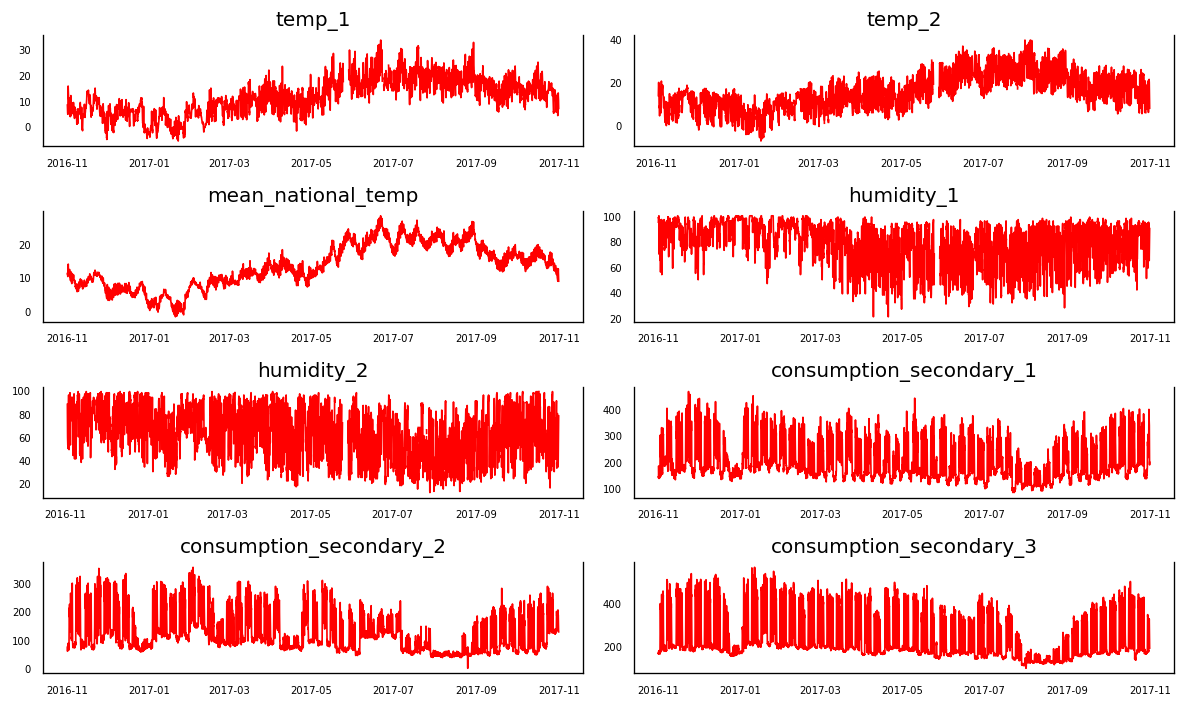

In [24]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [25]:
df1 = processing(df)

In [26]:
df1.index = pd.to_datetime(df.index)
df1.index

DatetimeIndex(['2016-11-01 00:00:00', '2016-11-01 01:00:00',
               '2016-11-01 02:00:00', '2016-11-01 03:00:00',
               '2016-11-01 04:00:00', '2016-11-01 05:00:00',
               '2016-11-01 06:00:00', '2016-11-01 07:00:00',
               '2016-11-01 08:00:00', '2016-11-01 09:00:00',
               ...
               '2017-10-31 14:00:00', '2017-10-31 15:00:00',
               '2017-10-31 16:00:00', '2017-10-31 17:00:00',
               '2017-10-31 18:00:00', '2017-10-31 19:00:00',
               '2017-10-31 20:00:00', '2017-10-31 21:00:00',
               '2017-10-31 22:00:00', '2017-10-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8760, freq=None)

In [27]:
df1.shape

(8760, 10)

In [28]:
df1.head(2)

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
timestamp,,,,,,,,,,
2016-11-01 00:00:00,8.3,11.738300,11.1,95.0,73.802381,143.0,74.0,168.0,100.0,93.0
2016-11-01 01:00:00,8.0,11.428133,11.1,98.0,75.122758,141.0,60.0,162.0,101.0,94.0


In [29]:
df2 = df1.copy()

## CHECK STATIONARITY


In [30]:
# Loop to check all columns of the DF

df2.apply(functools.partial(test_stationarity))

Results of Dickey-Fuller Test:
***   temp_1  *** Running ADF Stationarity test
Test Statistic                   -3.570275
p-value                           0.006355
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
	 Conclusion: Series is stationary at 95% CI

Results of Dickey-Fuller Test:
***   temp_2  *** Running ADF Stationarity test
Test Statistic                   -3.380647
p-value                           0.011637
#Lags Used                       33.000000
Number of Observations Used    8726.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
	 Conclusion: Series is stationary at 95% CI

Results of Dickey-Fuller Test:
***   mean_national_temp  *** Running ADF Stationarity test
Test Statistic             

temp_1                     Series is Stationary @95% CI
temp_2                     Series is Stationary @95% CI
mean_national_temp             Series is non-Stationary
humidity_1                 Series is Stationary @95% CI
humidity_2                 Series is Stationary @95% CI
consumption_secondary_1    Series is Stationary @95% CI
consumption_secondary_2    Series is Stationary @95% CI
consumption_secondary_3    Series is Stationary @95% CI
consumption_1              Series is Stationary @95% CI
consumption_2              Series is Stationary @95% CI
dtype: object

c/c : todo remove  mean_national_temp: Series is non-stationary.******* se pose la question, si une variable non_stationary, est ce que je dois differencing all the columns? 

quid de la sesonality? esssayer avec et aussi remove seasonality 

In [31]:
df2 = df2.resample('D').mean()

In [32]:
df1.shape


(8760, 10)

In [33]:
df2.shape

(365, 10)

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2016-11-01 to 2017-10-31
Freq: D
Data columns (total 10 columns):
temp_1                     365 non-null float64
temp_2                     365 non-null float64
mean_national_temp         365 non-null float64
humidity_1                 365 non-null float64
humidity_2                 365 non-null float64
consumption_secondary_1    365 non-null float64
consumption_secondary_2    365 non-null float64
consumption_secondary_3    365 non-null float64
consumption_1              365 non-null float64
consumption_2              365 non-null float64
dtypes: float64(10)
memory usage: 31.4 KB


In [35]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=2
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [36]:

grangers_causation_matrix(df2, variables = df2.columns)    

,temp_1_x,temp_2_x,mean_national_temp_x,humidity_1_x,humidity_2_x,consumption_secondary_1_x,consumption_secondary_2_x,consumption_secondary_3_x,consumption_1_x,consumption_2_x
temp_1_y,1.0000,0.0000,0.0,0.0916,0.0000,0.0261,0.1615,0.0173,0.0404,0.0098
temp_2_y,0.0000,1.0000,0.0,0.0033,0.0450,0.5837,0.8901,0.7958,0.4414,0.7883
mean_national_temp_y,0.0000,0.0017,1.0,0.0250,0.0004,0.0017,0.1298,0.0054,0.0180,0.0110
humidity_1_y,0.0000,0.0000,0.0,1.0000,0.0006,0.1283,0.1828,0.2078,0.0111,0.0274
humidity_2_y,0.0001,0.0000,0.0,0.0001,1.0000,0.0154,0.0024,0.0009,0.0000,0.0008
consumption_secondary_1_y,0.0000,0.0000,0.0,0.0001,0.0005,1.0000,0.0077,0.2560,0.0001,0.0000
consumption_secondary_2_y,0.0000,0.0000,0.0,0.0016,0.0001,0.0000,1.0000,0.0006,0.0415,0.0000
consumption_secondary_3_y,0.0000,0.0000,0.0,0.0001,0.0001,0.0001,0.0622,1.0000,0.0287,0.0000
consumption_1_y,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0202,0.0000,1.0000,0.0000
consumption_2_y,0.0000,0.0000,0.0,0.0036,0.1214,0.0000,0.0000,0.0000,0.0000,1.0000


In [37]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [38]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
temp_1 ::  3940.62   > 219.4051  =>   True
temp_2 ::  2249.57   > 179.5199  =>   True
mean_national_temp ::  1621.8    > 143.6691  =>   True
humidity_1 ::  1215.15   > 111.7797  =>   True
humidity_2 ::  847.82    > 83.9383   =>   True
consumption_secondary_1 ::  521.53    > 60.0627   =>   True
consumption_secondary_2 ::  307.36    > 40.1749   =>   True
consumption_secondary_3 ::  149.36    > 24.2761   =>   True
consumption_1 ::  12.03     > 12.3212   =>   False
consumption_2 ::  0.55      > 4.1296    =>   False


In [39]:
#split
nobs = 292
df1_train, df1_test = df1[0:-nobs], df1[-nobs:]

# Check size
print(df1_train.shape)  # (8468, 8)()
print(df1_test.shape)  # 292, 8)

(8468, 10)
(292, 10)


In [40]:
df1_train.index

DatetimeIndex(['2016-11-01 00:00:00', '2016-11-01 01:00:00',
               '2016-11-01 02:00:00', '2016-11-01 03:00:00',
               '2016-11-01 04:00:00', '2016-11-01 05:00:00',
               '2016-11-01 06:00:00', '2016-11-01 07:00:00',
               '2016-11-01 08:00:00', '2016-11-01 09:00:00',
               ...
               '2017-10-19 11:00:00', '2017-10-19 12:00:00',
               '2017-10-19 13:00:00', '2017-10-19 14:00:00',
               '2017-10-19 15:00:00', '2017-10-19 16:00:00',
               '2017-10-19 17:00:00', '2017-10-19 18:00:00',
               '2017-10-19 19:00:00', '2017-10-19 20:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8468, freq=None)

In [41]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':r[0], 'pvalue':r[1],  'n_lags':r[2], 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 5)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   
          
         

In [42]:
# ADF Test on each column
for name, column in df1_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temp_1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4892378140480806
 No. Lags Chosen       = 37
 Critical value 1%     = -3.43113
 Critical value 5%     = -2.86188
 Critical value 10%    = -2.56695
 => P-Value = 0.008267830055427462. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "temp_2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2854928709793247
 No. Lags Chosen       = 33
 Critical value 1%     = -3.43113
 Critical value 5%     = -2.86188
 Critical value 10%    = -2.56695
 => P-Value = 0.015539529003031082. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "mean_national_temp" 
    ------------------------------------------

In [43]:
df1_differenced = df1_train.diff(366).dropna()

In [44]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df1_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temp_1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.875391979482359
 No. Lags Chosen       = 37
 Critical value 1%     = -3.43116
 Critical value 5%     = -2.8619
 Critical value 10%    = -2.56696
 => P-Value = 4.859534981840352e-12. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "temp_2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.376553310340272
 No. Lags Chosen       = 33
 Critical value 1%     = -3.43116
 Critical value 5%     = -2.8619
 Critical value 10%    = -2.56696
 => P-Value = 8.691850452234386e-11. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "mean_national_temp" 
    --------------------------------------------

In [45]:
df1_train.head()

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
timestamp,,,,,,,,,,
2016-11-01 00:00:00,8.3,11.738300,11.1,95.0,73.802381,143.0,74.0,168.0,100.0,93.0
2016-11-01 01:00:00,8.0,11.428133,11.1,98.0,75.122758,141.0,60.0,162.0,101.0,94.0
2016-11-01 02:00:00,6.8,11.360615,11.0,97.0,74.975755,142.0,60.0,164.0,100.0,96.0
2016-11-01 03:00:00,7.5,11.136106,10.9,99.0,75.792810,139.0,60.0,162.0,101.0,95.0
2016-11-01 04:00:00,6.1,11.014923,10.8,98.0,75.896892,154.0,60.0,164.0,100.0,100.0


In [46]:
df1_differenced.head()

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
timestamp,,,,,,,,,,
2016-11-16 06:00:00,4.8,-10.438300,-2.7,0.0,23.197619,90.0,79.0,58.0,64.0,76.0
2016-11-16 07:00:00,4.9,-10.328133,-2.8,-3.0,21.877242,124.0,107.0,119.0,120.0,151.0
2016-11-16 08:00:00,5.9,-9.660615,-2.6,-2.0,23.024245,160.0,194.0,182.0,139.0,215.0
2016-11-16 09:00:00,5.0,-5.536106,-2.4,-5.0,23.207190,217.0,226.0,268.0,149.0,224.0
2016-11-16 10:00:00,6.5,-1.814923,-2.0,-6.0,-1.896892,234.0,239.0,305.0,166.0,207.0


In [47]:
model = VAR(df1_differenced)

/Users/schatagn/goinfre/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [48]:
model.select_order(30)

In [49]:
res= model.fit(maxlags=15, ic='aic')

In [50]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Jul, 2019
Time:                     21:36:19
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    31.5040
Nobs:                     8087.00    HQIC:                   30.6444
Log likelihood:          -235343.    FPE:                1.30188e+13
AIC:                      30.1974    Det(Omega_mle):     1.08200e+13
--------------------------------------------------------------------
Results for equation temp_1
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.006519         0.010779            0.605           0.545
L1.temp_1                           1.266084         0.014850           85.260           0.000
L1.

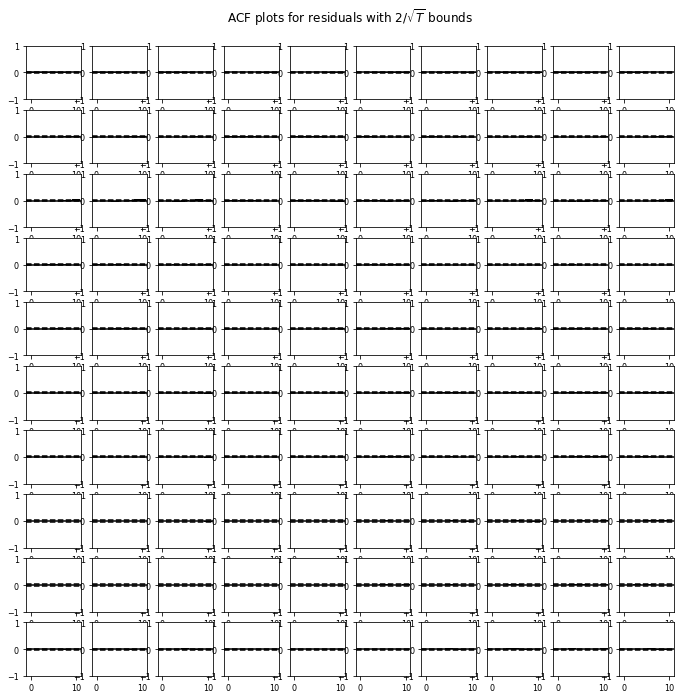

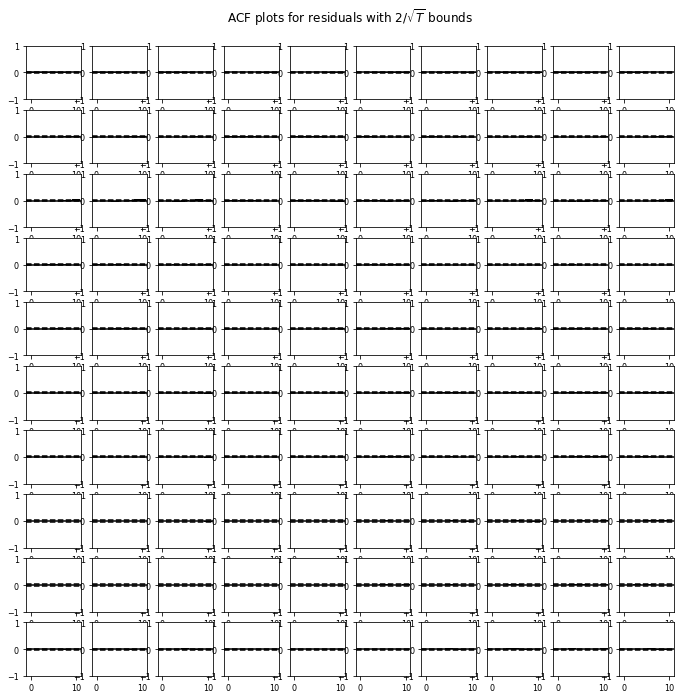

In [51]:
res.plot_acorr()

In [52]:

for i in [1,2,3,4,5,6,7,8,9, 10, 11, 12, 13, 14]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  34.803261985101535
BIC :  34.89830848638303
FPE :  1302760672268435.8
HQIC:  34.83577440573657 

Lag Order = 2
AIC :  32.130341853545566
BIC :  32.31181346608121
FPE :  89956017262193.8
HQIC:  32.19241797181755 

Lag Order = 3
AIC :  31.692655756243006
BIC :  31.96057077311388
FPE :  58069177431832.5
HQIC:  31.784302195118265 

Lag Order = 4
AIC :  31.537468743329203
BIC :  31.891845463828435
FPE :  49722049798591.24
HQIC:  31.658692128088163 

Lag Order = 5
AIC :  31.288637271240837
BIC :  31.729494000876496
FPE :  38768878383109.94
HQIC:  31.43944422947909 

Lag Order = 6
AIC :  31.080012459428943
BIC :  31.60736750992692
FPE :  31468724990739.8
HQIC:  31.260409621058358 

Lag Order = 7
AIC :  30.911814063405767
BIC :  31.525685752712665
FPE :  26596973891204.31
HQIC:  31.121808060655578 

Lag Order = 8
AIC :  30.735238500740984
BIC :  31.435645153027
FPE :  22291915223910.664
HQIC:  30.97483596815889 

Lag Order = 9
AIC :  30.677726048503533
BIC :  31.4646859941

In [53]:
x = model.select_order(maxlags=37)
x.summary()

,AIC,BIC,FPE,HQIC
0,59.34,59.35,5.907e+25,59.34
1,34.79,34.88,1.280e+15,34.82
2,32.11,32.30,8.846e+13,32.18
3,31.67,31.94,5.705e+13,31.77
4,31.52,31.88,4.887e+13,31.64
5,31.27,31.71,3.808e+13,31.42
6,31.06,31.59,3.089e+13,31.24
7,30.89,31.51,2.613e+13,31.10
8,30.72,31.42,2.197e+13,30.96
9,30.66,31.45,2.074e+13,30.93


In [54]:
model_fitted = model.fit(28)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Jul, 2019
Time:                     21:36:45
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    31.3221
Nobs:                     8074.00    HQIC:                   29.7202
Log likelihood:          -228372.    FPE:                3.51260e+12
AIC:                      28.8871    Det(Omega_mle):     2.49489e+12
--------------------------------------------------------------------
Results for equation temp_1
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.006128         0.010460            0.586           0.558
L1.temp_1                           1.220815         0.014747           82.784           0.000
L1.

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

Durbin Watson Statistic - Formula

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [55]:
from statsmodels.stats.stattools import durbin_watson


In [56]:
out = durbin_watson(model_fitted.resid)

In [57]:
for col, val in zip(df1.columns, out):
    print(col, ':', round(val, 2))

temp_1 : 2.0
temp_2 : 2.0
mean_national_temp : 2.01
humidity_1 : 2.0
humidity_2 : 2.0
consumption_secondary_1 : 2.0
consumption_secondary_2 : 2.0
consumption_secondary_3 : 2.0
consumption_1 : 2.0
consumption_2 : 2.0


In [58]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

28


In [59]:
# Input data for forecasting
forecast_input = df1_differenced.values[-lag_order:]
forecast_input

array([[ 7.40e+00,  1.00e+00,  2.00e+00, -1.00e+01, -1.30e+01, -5.80e+01,
        -2.70e+01, -3.60e+01,  4.10e+01, -4.40e+01],
       [ 5.10e+00, -1.70e+00,  1.30e+00,  1.00e+00, -2.00e+00, -4.90e+01,
        -3.20e+01, -7.90e+01, -1.60e+01, -5.60e+01],
       [ 3.20e+00, -4.20e+00,  5.00e-01,  1.10e+01,  6.00e+00, -7.50e+01,
        -2.40e+01, -9.40e+01, -4.20e+01, -6.80e+01],
       [ 1.40e+00, -5.40e+00, -3.00e-01,  1.50e+01,  8.00e+00, -1.14e+02,
        -4.70e+01, -1.39e+02, -8.20e+01, -5.80e+01],
       [-3.00e-01, -7.60e+00, -6.00e-01,  1.90e+01,  1.90e+01, -1.42e+02,
        -9.00e+01, -1.68e+02, -1.07e+02, -5.10e+01],
       [-1.90e+00, -9.20e+00, -8.00e-01,  3.30e+01,  2.30e+01, -1.24e+02,
        -1.15e+02, -1.69e+02, -1.24e+02, -5.60e+01],
       [-1.70e+00, -9.50e+00, -1.10e+00,  3.60e+01,  3.20e+01, -1.17e+02,
        -8.60e+01, -1.21e+02, -1.11e+02, -3.80e+01],
       [-2.30e+00, -8.20e+00, -5.00e-01,  3.50e+01,  2.90e+01, -8.10e+01,
        -4.20e+01, -7.90e+01, -8.50e+

In [60]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,temp_1_1d,temp_2_1d,mean_national_temp_1d,humidity_1_1d,humidity_2_1d,consumption_secondary_1_1d,consumption_secondary_2_1d,consumption_secondary_3_1d,consumption_1_1d,consumption_2_1d
timestamp,,,,,,,,,,
2017-10-19 21:00:00,0.958424,-6.239940,-0.354754,16.876387,18.856344,-76.812803,-68.392942,-190.440059,-119.103155,-60.300322
2017-10-19 22:00:00,-0.061882,-7.104041,-0.600416,19.853856,24.831334,-75.636539,-70.048095,-171.507981,-121.583308,-63.917047
2017-10-19 23:00:00,-1.019804,-7.379041,-0.795641,24.099640,28.735209,-63.301984,-60.027361,-123.476360,-108.424542,-43.965391
2017-10-20 00:00:00,-1.379454,-6.407682,-0.281785,25.147461,25.578276,-29.991483,-23.891194,-69.427154,-80.527996,-11.048576
2017-10-20 01:00:00,-1.606584,-5.178401,0.185160,25.037373,22.513510,0.034252,4.393006,-19.259217,-47.318293,10.425430
2017-10-20 02:00:00,-1.324249,-3.757796,0.565739,22.238241,16.799407,19.491805,26.474474,23.668011,-10.078064,23.897104
2017-10-20 03:00:00,-0.702232,-2.270180,0.853440,17.927036,11.800884,66.107032,47.870992,59.313256,16.791038,27.081758
2017-10-20 04:00:00,-0.341056,-0.756532,1.019869,15.841002,3.443534,85.897284,55.929471,72.451783,31.660906,33.055108
2017-10-20 05:00:00,0.340015,0.609240,1.120403,12.620954,-1.697369,86.622790,67.064934,79.919868,38.003387,36.771338


In [61]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [62]:
df_results = invert_transformation(df1_train, df_forecast, second_diff=False)
df_results.columns

Index(['temp_1_1d', 'temp_2_1d', 'mean_national_temp_1d', 'humidity_1_1d',
       'humidity_2_1d', 'consumption_secondary_1_1d',
       'consumption_secondary_2_1d', 'consumption_secondary_3_1d',
       'consumption_1_1d', 'consumption_2_1d', 'temp_1_forecast',
       'temp_2_forecast', 'mean_national_temp_forecast', 'humidity_1_forecast',
       'humidity_2_forecast', 'consumption_secondary_1_forecast',
       'consumption_secondary_2_forecast', 'consumption_secondary_3_forecast',
       'consumption_1_forecast', 'consumption_2_forecast'],
      dtype='object')

In [63]:
df_results.loc[:,[ 'temp_1_forecast',
       'temp_2_forecast', 'mean_national_temp_forecast', 'humidity_1_forecast',
       'humidity_2_forecast', 'consumption_secondary_1_forecast',
       'consumption_secondary_2_forecast', 'consumption_secondary_3_forecast',
       'consumption_1_forecast', 'consumption_2_forecast']]

,temp_1_forecast,temp_2_forecast,mean_national_temp_forecast,humidity_1_forecast,humidity_2_forecast,consumption_secondary_1_forecast,consumption_secondary_2_forecast,consumption_secondary_3_forecast,consumption_1_forecast,consumption_2_forecast
timestamp,,,,,,,,,,
2017-10-19 21:00:00,19.558424,12.360060,16.345246,82.876387,84.856344,163.187197,45.607058,48.559941,24.896845,68.699678
2017-10-19 22:00:00,19.496542,5.256019,15.744830,102.730243,109.687678,87.550658,-24.441037,-122.948040,-96.686463,4.782631
2017-10-19 23:00:00,18.476738,-2.123023,14.949189,126.829882,138.422886,24.248674,-84.468398,-246.424400,-205.111005,-39.182760
2017-10-20 00:00:00,17.097284,-8.530705,14.667404,151.977343,164.001162,-5.742809,-108.359592,-315.851554,-285.639001,-50.231337
2017-10-20 01:00:00,15.490700,-13.709106,14.852563,177.014717,186.514672,-5.708557,-103.966586,-335.110771,-332.957294,-39.805907
2017-10-20 02:00:00,14.166451,-17.466902,15.418303,199.252957,203.314080,13.783249,-77.492112,-311.442760,-343.035358,-15.908803
2017-10-20 03:00:00,13.464219,-19.737083,16.271743,217.179994,215.114964,79.890281,-29.621119,-252.129504,-326.244319,11.172954
2017-10-20 04:00:00,13.123163,-20.493615,17.291612,233.020996,218.558498,165.787565,26.308352,-179.677721,-294.583413,44.228062
2017-10-20 05:00:00,13.463178,-19.884375,18.412015,245.641950,216.861129,252.410355,93.373286,-99.757853,-256.580026,80.999401


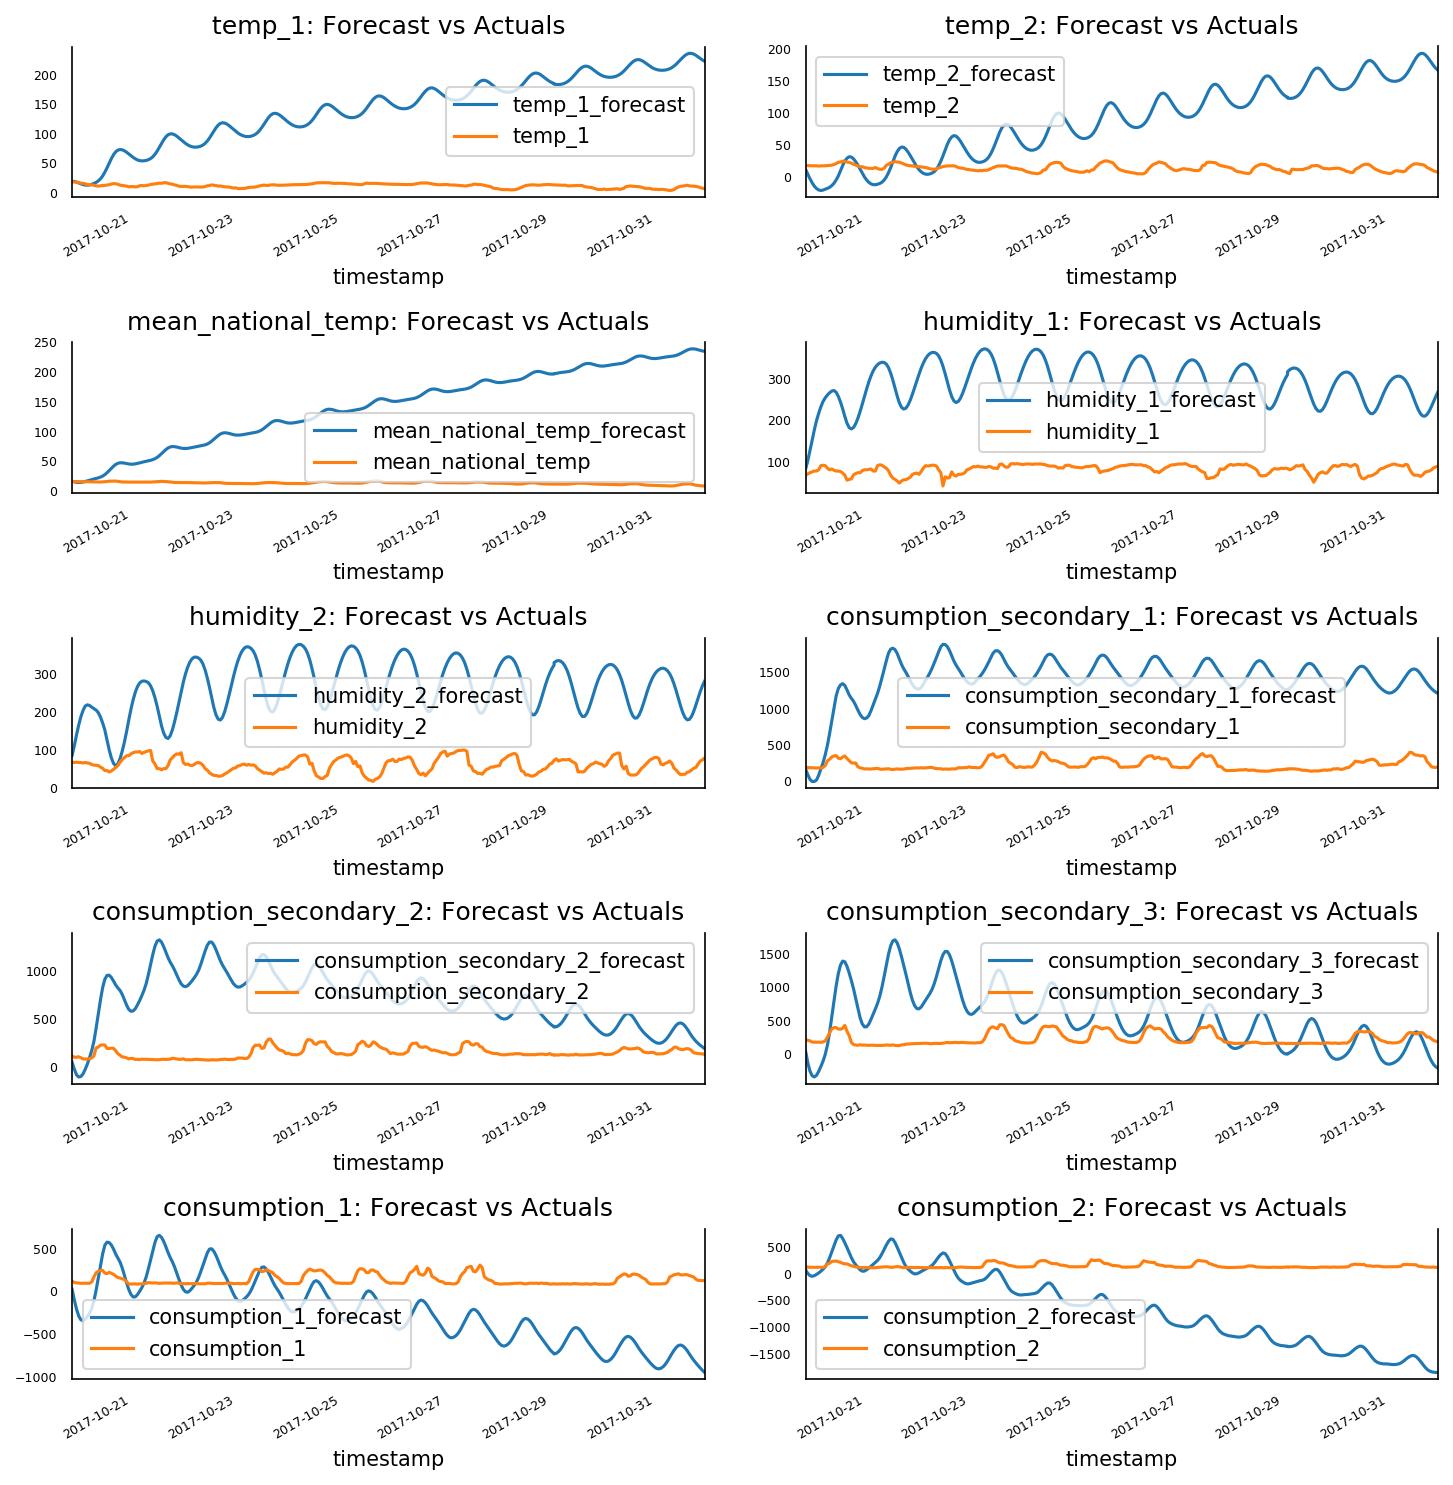

In [64]:
fig, axes = plt.subplots(nrows=int(len(df1.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df1.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df1_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [65]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: temp_1')
accuracy_prod = forecast_accuracy(df_results['temp_1_forecast'].values, df1_test['temp_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: temp_2')
accuracy_prod = forecast_accuracy(df_results['temp_2_forecast'].values, df1_test['temp_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: mean_national_temp')
accuracy_prod = forecast_accuracy(df_results['mean_national_temp_forecast'].values, df1_test['mean_national_temp'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))
print('\nForecast Accuracy of: humidity_1')
accuracy_prod = forecast_accuracy(df_results['humidity_1_forecast'].values, df1_test['humidity_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: humidity_2')
accuracy_prod = forecast_accuracy(df_results['humidity_2_forecast'].values, df1_test['humidity_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_secondary_1')
accuracy_prod = forecast_accuracy(df_results['consumption_secondary_1_forecast'].values, df1_test['consumption_secondary_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_secondary_2')
accuracy_prod = forecast_accuracy(df_results['consumption_secondary_2_forecast'].values, df1_test['consumption_secondary_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_secondary_3')
accuracy_prod = forecast_accuracy(df_results['consumption_secondary_3_forecast'].values, df1_test['consumption_secondary_3'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_1')
accuracy_prod = forecast_accuracy(df_results['consumption_1_forecast'].values, df1_test['consumption_1'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: consumption_2')
accuracy_prod = forecast_accuracy(df_results['consumption_2_forecast'].values, df1_test['consumption_2'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: temp_1
mape :  12.7102
me :  131.5832
mae :  131.6304
mpe :  12.7072
rmse :  143.9515
corr :  -0.3538
minmax :  0.8667

Forecast Accuracy of: temp_2
mape :  6.3831
me :  74.0413
mae :  79.6075
mpe :  6.0534
rmse :  94.4224
corr :  -0.0798
minmax :  0.8521

Forecast Accuracy of: mean_national_temp
mape :  10.1919
me :  129.2794
mae :  129.3131
mpe :  10.1898
rmse :  144.5887
corr :  -0.6939
minmax :  0.8428

Forecast Accuracy of: humidity_1
mape :  2.5187
me :  204.8237
mae :  204.8237
mpe :  2.5187
rmse :  209.786
corr :  0.5669
minmax :  0.7067

Forecast Accuracy of: humidity_2
mape :  3.7771
me :  203.9977
mae :  203.9977
mpe :  3.7771
rmse :  213.8128
corr :  0.4612
minmax :  0.7565

Forecast Accuracy of: consumption_secondary_1
mape :  5.7403
me :  1174.0199
mae :  1180.5063
mpe :  5.7048
rmse :  1213.923
corr :  0.2345
minmax :  0.8315

Forecast Accuracy of: consumption_secondary_2
mape :  4.6858
me :  552.8195
mae :  560.3498
mpe :  4.6045
rmse :  623.1387
c